In [ ]:
#uncomment if you use Google Colab

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
# cd in the directory with the dataset

## Loading the dataset

In [ ]:
import pandas as pd
import numpy as np

colnames = ["S_Mean", "S_Max-Min", "S_Max-|Min|", "S_sumYup - sumYdn", "S_(Max-Mean)/(Mean-Min))", "S_numYup - numYdn", 
            "S_maxBd", "S_RangeJDy", "S_F", "S_Ph",
            "L_Mean", "L_Max-Min", "L_Max-|Min|", "L_sumYup - sumYdn", "L_(Max-Mean)/(Mean-Min))", "L_numYup - numYdn", 
            "L_maxBd", "L_RangeJDy", "L_F", "L_Ph",
            "y"]
phase_colnames = []
abs_colnames = []
for f_name in colnames:
    phase_colnames.append(f_name + "_phase")
    abs_colnames.append(f_name + "_abs")

data_phase = pd.read_csv('COMP_PHASE_difference_10_devices_802_11_a_L_STF_LTF_dataset_Hyp1.txt', sep=",", names=phase_colnames, header=None)
data_abs = pd.read_csv('ABS_difference_10_devices_802_11_a_L_STF_LTF_dataset_Hyp1.txt', sep=",", names=abs_colnames, header=None)

data = pd.concat([data_abs.drop("y_abs", axis=1), data_phase], axis=1)

data = data.replace([np.inf, -np.inf, np.nan], 0)

data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   S_Mean_abs                      14000 non-null  float64
 1   S_Max-Min_abs                   14000 non-null  float64
 2   S_Max-|Min|_abs                 14000 non-null  float64
 3   S_sumYup - sumYdn_abs           14000 non-null  float64
 4   S_(Max-Mean)/(Mean-Min))_abs    14000 non-null  float64
 5   S_numYup - numYdn_abs           14000 non-null  int64  
 6   S_maxBd_abs                     14000 non-null  float64
 7   S_RangeJDy_abs                  14000 non-null  float64
 8   S_F_abs                         14000 non-null  float64
 9   S_Ph_abs                        14000 non-null  float64
 10  L_Mean_abs                      14000 non-null  float64
 11  L_Max-Min_abs                   14000 non-null  float64
 12  L_Max-|Min|_abs                 

In [ ]:
data.describe()

,S_Mean_abs,S_Max-Min_abs,S_Max-|Min|_abs,S_sumYup - sumYdn_abs,S_(Max-Mean)/(Mean-Min))_abs,S_numYup - numYdn_abs,S_maxBd_abs,S_RangeJDy_abs,S_F_abs,S_Ph_abs,L_Mean_abs,L_Max-Min_abs,L_Max-|Min|_abs,L_sumYup - sumYdn_abs,L_(Max-Mean)/(Mean-Min))_abs,L_numYup - numYdn_abs,L_maxBd_abs,L_RangeJDy_abs,L_F_abs,L_Ph_abs,S_Mean_phase,S_Max-Min_phase,S_Max-|Min|_phase,S_sumYup - sumYdn_phase,S_(Max-Mean)/(Mean-Min))_phase,S_numYup - numYdn_phase,S_maxBd_phase,S_RangeJDy_phase,S_F_phase,S_Ph_phase,L_Mean_phase,L_Max-Min_phase,L_Max-|Min|_phase,L_sumYup - sumYdn_phase,L_(Max-Mean)/(Mean-Min))_phase,L_numYup - numYdn_phase,L_maxBd_phase,L_RangeJDy_phase,L_F_phase,L_Ph_phase,y_phase
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,1.400000e+04,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,1.400000e+04,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,-0.007460,0.910944,0.010862,34.918269,1.060130,-6.523571,16.332930,3.286337,1.680959,1.576431,-0.008969,0.980620,0.023202,37.540256,1.094057,-7.262143,17.442292,3.334217,1.914735,1.566316,2.450126e-16,4.297329,0.222321,204.459501,1.199960,3.043714,101.078150,8.210220,0.666397,1.492645,-4.016957e-15,8.703483,0.164851,442.771698,1.156099,-0.861286,219.112373,10.585512,0.933126,1.354525,6.500000
std,0.011927,0.394089,0.097193,14.511092,0.205226,15.245924,6.212932,1.730175,0.359406,0.853997,0.012331,0.402302,0.101015,15.086020,0.188345,12.619297,6.667779,1.898042,0.352979,0.899704,9.356848e-16,15.871435,1.909267,955.643967,0.806078,27.923990,473.790058,7.946448,0.385077,0.951236,2.898644e-15,19.892895,2.936157,1211.032647,0.608654,39.913052,600.517024,11.541276,0.475815,1.009190,2.872384
min,-0.132200,0.140070,-0.562510,5.470500,0.522810,-150.000000,2.634800,0.725990,0.146220,0.000011,-0.085286,0.136480,-0.591570,4.957400,0.437140,-84.000000,2.218200,0.601490,0.922040,0.000465,-3.209300e-14,0.230440,-31.166000,7.398200,0.135150,-194.000000,3.643000,0.841660,0.000000,0.000000,-3.458000e-14,0.421810,-50.555000,9.403700,0.199400,-204.000000,4.513600,0.753480,0.000000,0.000000,2.000000
25%,-0.009886,0.654967,-0.045053,24.745250,0.916300,-16.000000,11.770750,1.946400,1.439275,0.933998,-0.011854,0.708065,-0.034076,26.601750,0.960175,-16.000000,12.483750,1.797250,1.629600,0.797422,7.586500e-17,1.365350,-0.070018,47.293000,0.909550,-4.000000,23.165750,2.931025,0.412158,0.642467,-5.728800e-15,2.081400,-0.259563,51.133750,0.841675,-12.000000,25.065000,2.369075,0.930708,0.386902,4.000000
50%,-0.003917,0.884440,0.006871,34.241500,1.048800,-6.000000,16.299000,2.888200,1.739700,1.598600,-0.004387,0.972840,0.022618,37.464000,1.091500,-6.000000,17.517500,2.840650,1.948300,1.551100,2.419400e-16,1.972450,0.029899,69.949500,1.038000,2.000000,34.356000,4.954650,0.569570,1.495850,-4.022700e-15,3.128200,0.073693,81.248000,1.059100,-2.000000,39.791000,5.600600,1.074800,1.329600,6.500000
75%,-0.000508,1.118700,0.062605,44.255250,1.187600,2.000000,20.781250,4.243600,2.009400,2.226500,-0.000994,1.208875,0.083447,47.232000,1.218400,2.000000,22.219250,4.622975,2.236000,2.335200,4.039575e-16,2.606150,0.174172,97.324250,1.194725,12.000000,47.979500,10.334250,0.872955,2.306775,-2.331500e-15,4.323775,0.367010,115.312500,1.303250,8.000000,56.561500,14.013750,1.177425,2.233375,9.000000
max,0.014751,3.706100,1.465900,117.440000,3.524800,46.000000,45.797000,32.741000,2.156600,3.140600,0.028431,3.374100,1.244400,111.550000,3.102600,36.000000,46.866000,17.550000,2.525600,3.141500,3.233000e-14,305.550000,75.210000,18720.000000,21.244000,190.000000,9283.300000,50.132000,3.069000,3.141500,3.801400e-14,353.150000,26.594000,21227.000000,9.557400,198.000000,10525.000000,51

In [ ]:
import numpy as np

X = np.array(data.drop("y_phase", axis=1))
y = np.array(data ["y_phase"]) - 2

## Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, stratify=y)

## Baseline Classifiers

In [ ]:
from sklearn.model_selection import GridSearchCV
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

params = {'max_depth' : range(1, 25),
          }


clf = DecisionTreeClassifier()
dt = GridSearchCV(clf, params, n_jobs=-1, cv=3)
dt.fit(X_train, y_train)
dt_best_params = dt.best_params_
dt = dt.best_estimator_
# print('f1: \t{:.4}'.format(f1_score(y_test, dt.predict(X_test), average='macro')))
y_pred = dt.predict(X_test)
print('acc:\t{:.4}'.format(accuracy_score(y_test, y_pred)))
print('best params {}'.format(dt_best_params))

acc:	0.8738
best params {'max_depth': 9}


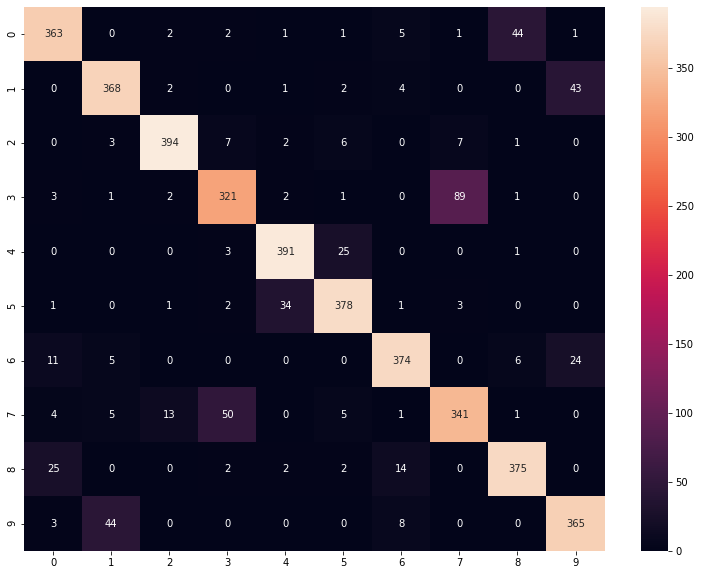

In [ ]:
plt.figure(figsize=(13, 10))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.show() 

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# import progressbar
from tqdm import tqdm_notebook as tqdm

#simple hyperparameters search
RF = RandomForestClassifier()
RF_acc = []

for i in tqdm(range(1, 50)):
    RF.n_estimators = i
    RF.fit(X_train, y_train)
    RF_acc.append(accuracy_score(RF.predict(X_test), y_test))
        
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


0.9330952380952381


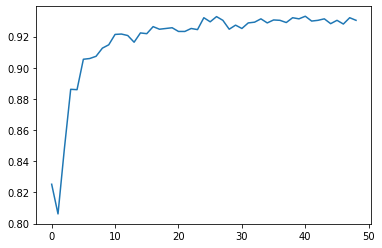

In [ ]:
plt.plot(RF_acc)
print(max(RF_acc))

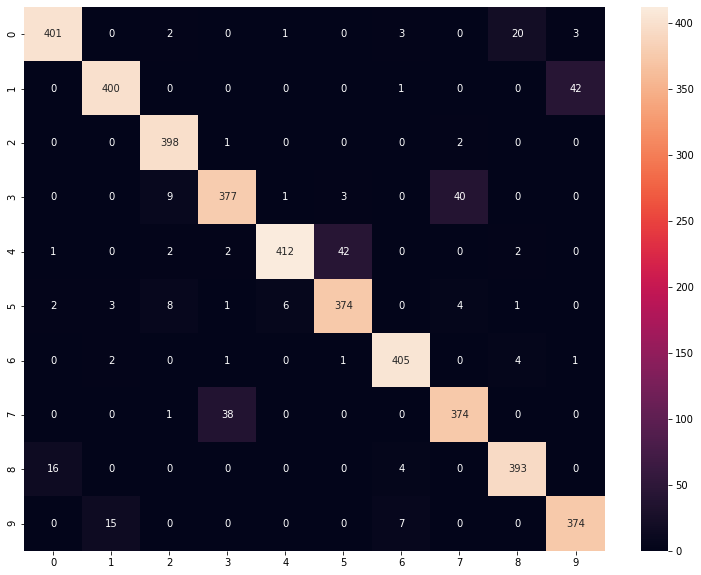

In [ ]:
plt.figure(figsize=(13, 10))
cf_matrix = confusion_matrix(RF.predict(X_test), y_test)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.show() 

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(random_state=0, learning_rate=0.3, n_estimators=200)
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
clf.score(X_test, y_test)

0.9414285714285714

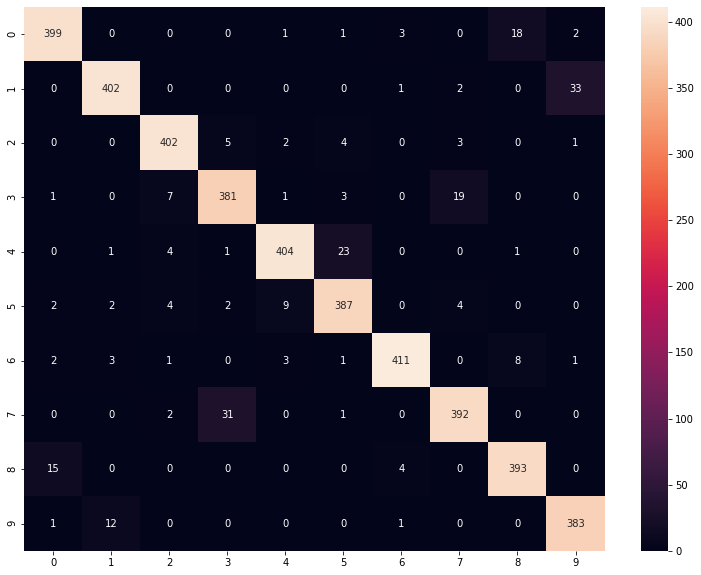

In [ ]:
plt.figure(figsize=(13, 10))
cf_matrix = confusion_matrix(clf.predict(X_test), y_test)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.show() 

# Labels, title and ticks
# label_font = {'size':'18'}  # Adjust to fit
# ax.set_xlabel('Predicted labels', fontdict=label_font);
# ax.set_ylabel('True labels', fontdict=label_font);

# title_font = {'size':'21'}  # Adjust to fit
# ax.set_title('Confusion Matrix', fontdict=title_font);

# plt.show() 

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
# params = {"max_depth" : range(3, 15), 
#           "learning_rate" : np.linspace(0.01, 1, 3),
#           "n_estimators" : range(100, 400, 100)}
params={}
clf = xgb.XGBClassifier()
clf = GridSearchCV(clf, params, n_jobs=-1, cv=3, verbose=2)
clf.fit(X_train, y_train)
xgb_best_params = clf.best_params_
clf = clf.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.0s finished


In [ ]:
y_pred = clf.predict(X_test)
print('acc:\t{:.4}'.format(accuracy_score(y_test, y_pred)))
print('best params {}'.format(xgb_best_params))

acc:	0.925
best params {}


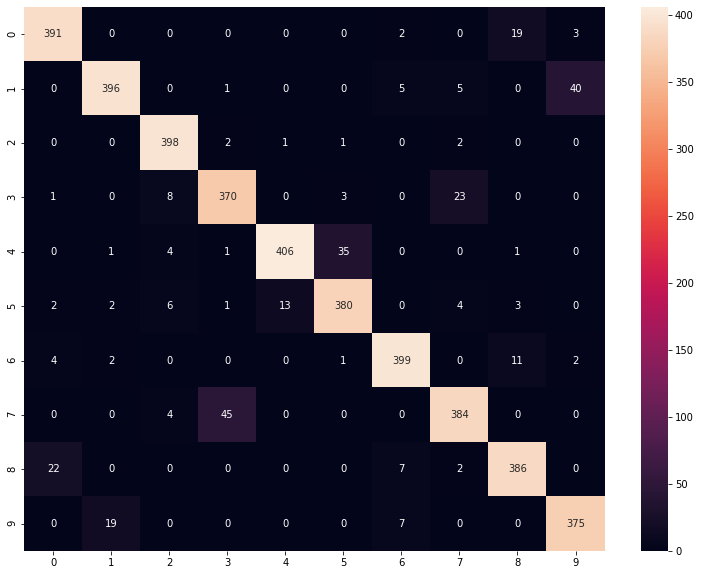

In [ ]:
plt.figure(figsize=(13, 10))
cf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.show() 

## Best model's (Random Forest) hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# import progressbar
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score

# Number of trees in random forest
n_estimators = [200, 500, 1000, 2500, 5000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 50, 70]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_tuned = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_tuned.fit(X_train, y_train)
rf_acc = accuracy_score(rf.predict(X_test), y_test)
rf_tuned_acc = accuracy_score(rf_tuned.predict(X_test), y_test)
print ('base model accuracy: {}\ntuned model accuracy: {}'.format(rf_acc, rf_tuned_acc))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  7.5min finished


base model accuracy: 0.934047619047619
tuned model accuracy: 0.934047619047619


In [ ]:
rf_tuned.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 5000}

## Feature importance analysis

Try something from here
https://scikit-learn.org/stable/modules/feature_selection.html

Mean decrease impurity

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
#Load boston housing dataset as an example
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), colnames), 
             reverse=True))

Features sorted by their score:
[(0.2527, 'L_Mean'), (0.2083, 'S_Mean'), (0.0485, 'S_RangeJDy'), (0.0284, 'S_F'), (0.0198, 'S_Max-Min'), (0.0175, 'L_maxBd'), (0.0172, 'L_Max-Min'), (0.012, 'L_RangeJDy'), (0.0093, 'L_F'), (0.0075, 'S_(Max-Mean)/(Mean-Min))'), (0.0061, 'S_Max-|Min|'), (0.0053, 'S_sumYup - sumYdn'), (0.0053, 'L_sumYup - sumYdn'), (0.0051, 'L_Ph'), (0.0046, 'S_Ph'), (0.0043, 'L_numYup - numYdn'), (0.0041, 'y'), (0.0041, 'L_Max-|Min|'), (0.004, 'L_(Max-Mean)/(Mean-Min))'), (0.0036, 'S_numYup - numYdn'), (0.0033, 'S_maxBd')]


Another method 

In [ ]:
import pandas as pd
#from sklearn.ensemble import RandomForestClassfier
from sklearn.feature_selection import SelectFromModel


In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [ ]:
sel.get_support()

array([ True,  True, False,  True, False, False, False,  True,  True,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False,  True, False,
        True, False, False, False,  True, False,  True, False, False,
        True,  True, False, False])

In [ ]:
X_train_dataframe = pd.DataFrame(X_train)
selected_feat_train = X_train_dataframe.columns[(sel.get_support())]
len(selected_feat)
selected_feat_test = X_test_dataframe.columns[(sel.get_support())]

14

In [ ]:
print(selected_feat_train)

Int64Index([0, 1, 3, 7, 8, 10, 17, 18, 25, 27, 31, 33, 36, 37], dtype='int64')


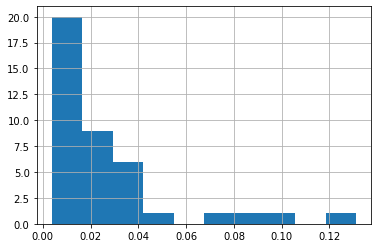

In [ ]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()